In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

In [2]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

def make_ws_graph(n, k, p = 0.1):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p = 0.5):
    """Returns True with probability `p`."""
    return np.random.random() < p

def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]


def make_ba_graph(n, k, seed=None):
    """Constructs a BA graph.
    
    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.
    
    repeated_nodes: list of nodes
    k: size of set
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

In [3]:
cooperate = np.array([1,0])
defect    = np.array([0,1])
b         = 1.62
payoffM   = np.array([[1,0],[b,0]])
def payoff(A, B):
    return A.dot(payoffM.dot(B))

class Player():
    def __init__(self, strategy, cost):
        self.strat    = strategy
        self.cost     = cost
    def payoff(self, opponent):
        return payoff(self.strat, opponent.strat)
    def fitness(self, opponents):
        return np.sum([self.payoff(o) for o in opponents])-self.cost
    def __str__(self):
        return "%s:%.2f"%(str(self.strat),self.cost)

def random_player(use_cost = True):
    strategy = cooperate if flip() else defect
    cost     = np.random.uniform(0,1) if use_cost else 0
    return Player(strategy,cost)
    
class Network():
    def __init__(self, constructor, N, k=4, use_cost = True):
        self.players = np.array([random_player(use_cost) for _ in range(N)])
        self.network = make_ring_lattice(N, k)
        self.N       = N
        self.mean_fits     = []
        self.n_coops       = []
        self.n_defects     = []
        self.mean_costs    = []
    def fitness(self):
        for i,p in enumerate(self.players):
            opponents = list(self.network[i])
            yield p.fitness(self.players[opponents])
    def max_fitness(self, fitness):
        for i,p in enumerate(self.players):
            neighbors = list(self.network[i])
            neighbors.append(i)
            fits = fitness[neighbors]
            index = np.random.choice(np.flatnonzero(fits == fits.max()))
            yield neighbors[index]
        
    def step(self):
        fitness  = np.array(list(self.fitness()))
        mean_fit = np.mean(fitness)
        strats   = [p.strat for p in self.players]
        costs    = [p.cost for  p in self.players]
        n_coop, n_defect = np.sum(strats, 0)
        mean_cost = np.mean(costs)
        
        self.mean_fits.append(mean_fit)
        self.n_coops.append(n_coop)
        self.n_defects.append(n_defect)
        self.mean_costs.append(mean_cost)
        
        max_fits = list(self.max_fitness(fitness))
        self.players = self.players[max_fits]
        

In [4]:
def run_network(net, T = 400):
    for _ in range(T):
        net.step()

def plot_network(net):
    plt.figure(figsize = (13,8))
    plt.subplot(2,2,1)
    plt.plot(net.mean_fits)
    plt.title('mean fitness over time')

    plt.subplot(2,2,2)
    plt.plot(net.mean_costs)
    plt.title('mean cost over time')

    plt.subplot(2,2,3)
    plt.plot(net.n_coops)
    plt.title('number of cooperators over time')

    plt.subplot(2,2,4)
    plt.plot(net.n_defects)
    plt.title('number of defectors over time');

def plot_networks(nets, labels):
    plt.figure(figsize = (13,8))
    plt.subplot(2,2,1)
    for net,label in zip(nets,labels):
        plt.plot(net.mean_fits, label=label)
    plt.title('mean fitness over time')
    plt.legend()

    plt.subplot(2,2,2)
    for net,label in zip(nets,labels):
        plt.plot(net.mean_costs, label=label)
    plt.title('mean cost over time')
    plt.legend()

    plt.subplot(2,2,3)
    for net,label in zip(nets,labels):
        plt.plot(net.n_coops, label=label)
    plt.title('number of cooperators over time')
    plt.legend()

    plt.subplot(2,2,4)
    for net,label in zip(nets,labels):
        plt.plot(net.n_defects, label=label)
    plt.title('number of defectors over time')
    plt.legend()

In [5]:
ring_lattice_cost = Network(make_ring_lattice, 1000)
run_network(ring_lattice_cost)

Ring lattice with cost


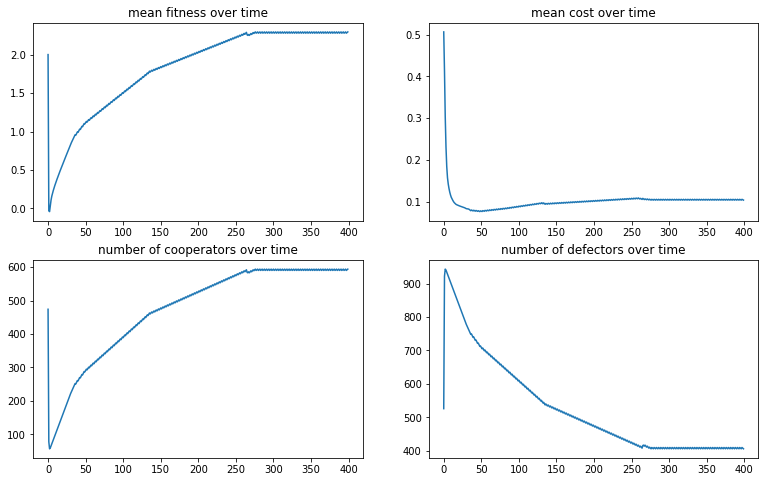

In [6]:
print("Ring lattice with cost")
plot_network(ring_lattice_cost)

In [7]:
ring_lattice_nocost = Network(make_ring_lattice, 1000, use_cost = False)
run_network(ring_lattice_nocost)

Ring lattice without cost


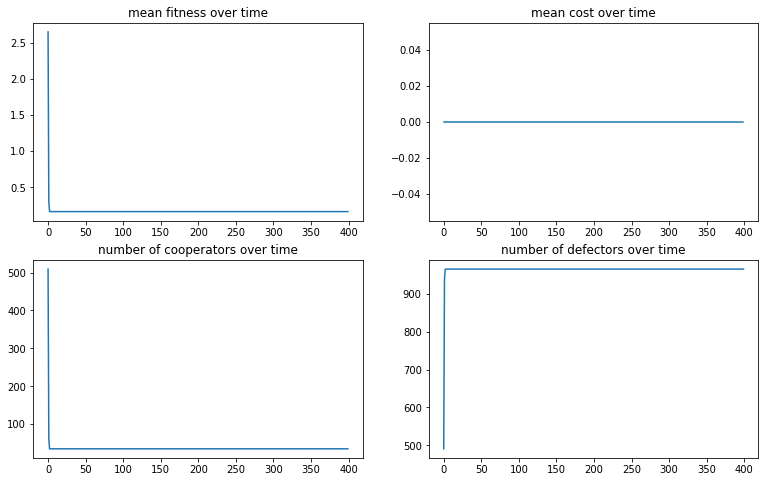

In [8]:
print("Ring lattice without cost")
plot_network(ring_lattice_nocost)

In [9]:
ws_cost = Network(make_ws_graph, 1000)
run_network(ws_cost)

WS with cost


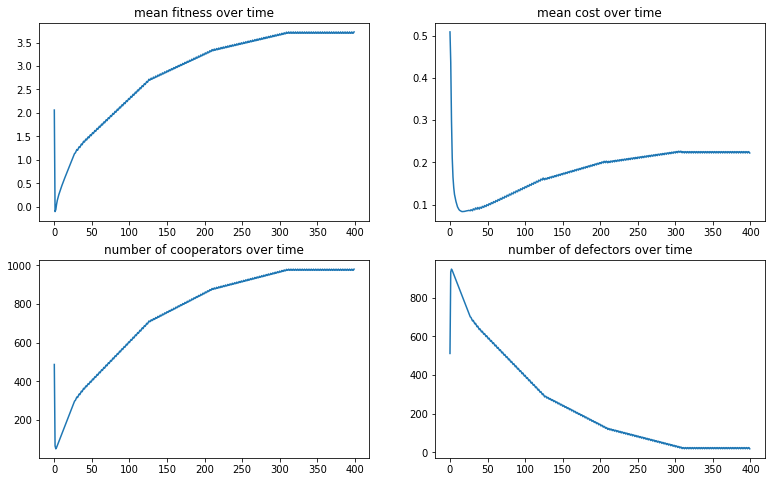

In [10]:
print("WS with cost")
plot_network(ws_cost)

In [11]:
ws_nocost = Network(make_ws_graph, 1000, use_cost=False)
run_network(ws_nocost)

WS without cost


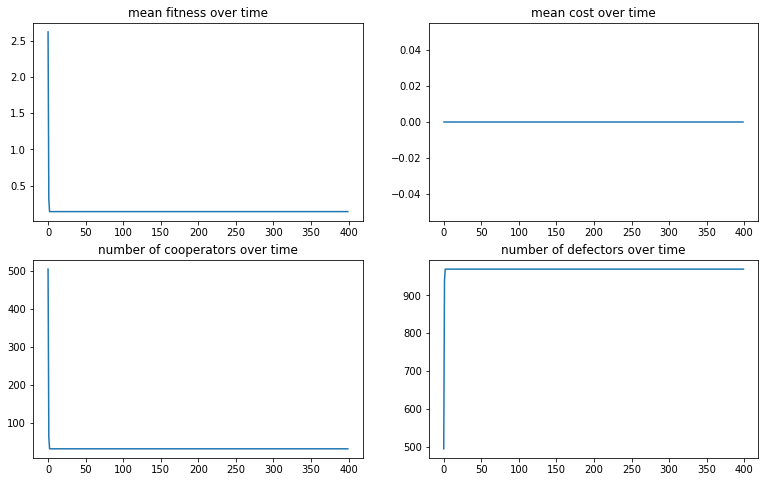

In [12]:
print("WS without cost")
plot_network(ws_nocost)

In [13]:
ba_cost = Network(make_ba_graph, 1000)
run_network(ba_cost)

BA with cost


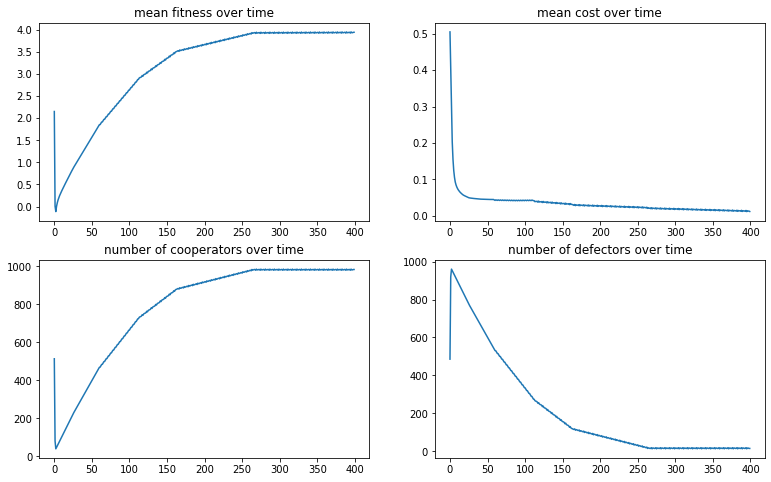

In [14]:
print("BA with cost")
plot_network(ba_cost)

In [15]:
ba_nocost = Network(make_ba_graph, 1000, use_cost=False)
run_network(ba_nocost)

BA without cost


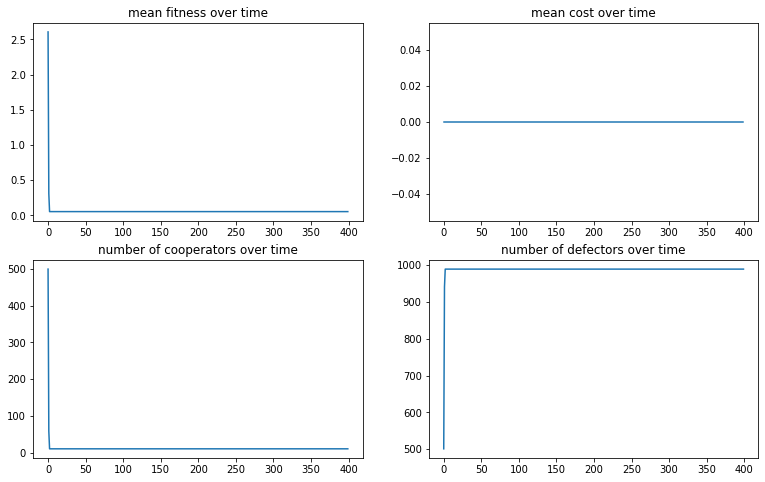

In [16]:
print("BA without cost")
plot_network(ba_nocost)

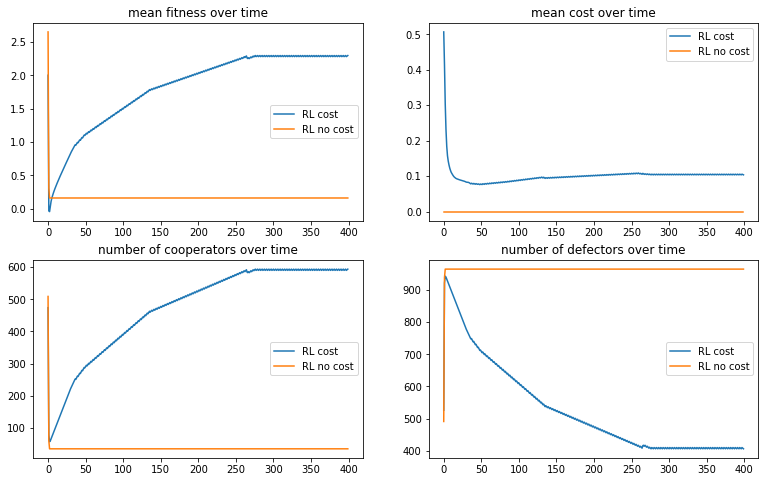

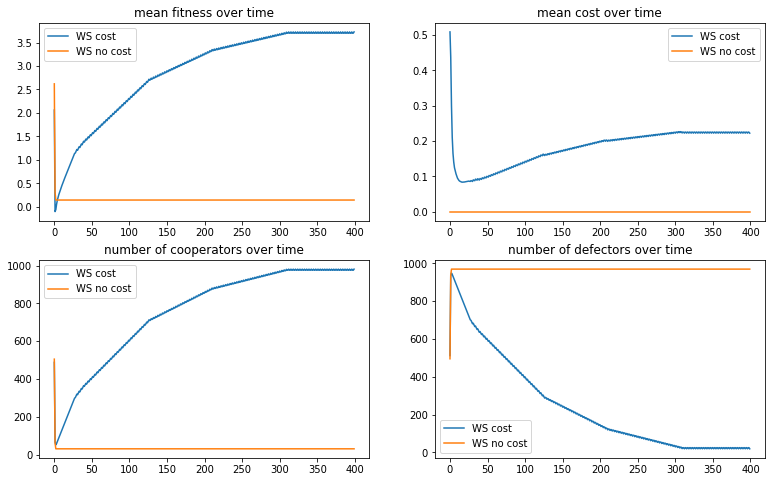

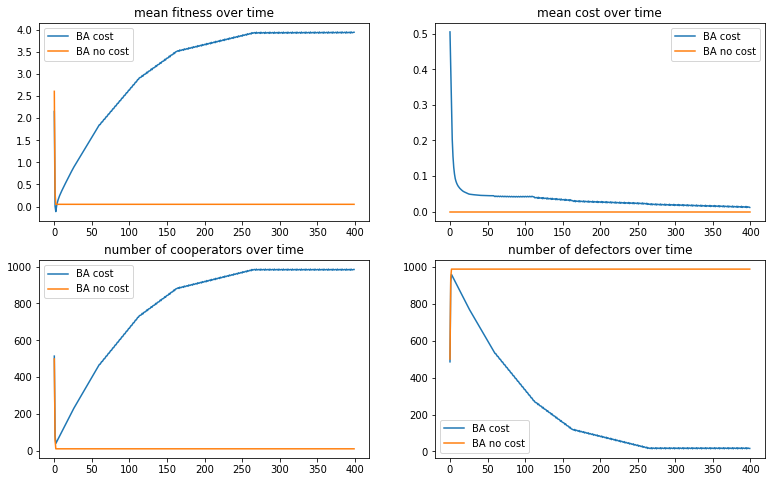

In [17]:
nets = [[ring_lattice_cost, ring_lattice_nocost],[ws_cost, ws_nocost], [ba_cost, ba_nocost]]
labels = [['RL cost', 'RL no cost'],['WS cost', 'WS no cost'],['BA cost', 'BA no cost']]
for net,lab in zip(nets,labels):
    plot_networks(net, lab)

The original paper used $b=0.5$, but with $b=0.62$ the decision costr 